In [81]:
# Libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import curve_fit
from matplotlib import colors as mcolors

# Plot parameters
plt.rcParams.update({
    'lines.linewidth': 2,     # linewidth
    'text.usetex': True,      # LaTeX font
    'font.family': 'serif',   # Serif family
    'font.size': 16,          # font size
    'axes.titlesize': 18,     # title size
    'axes.grid': True,        # grid
    'grid.linestyle': "-.",   # grid style
})

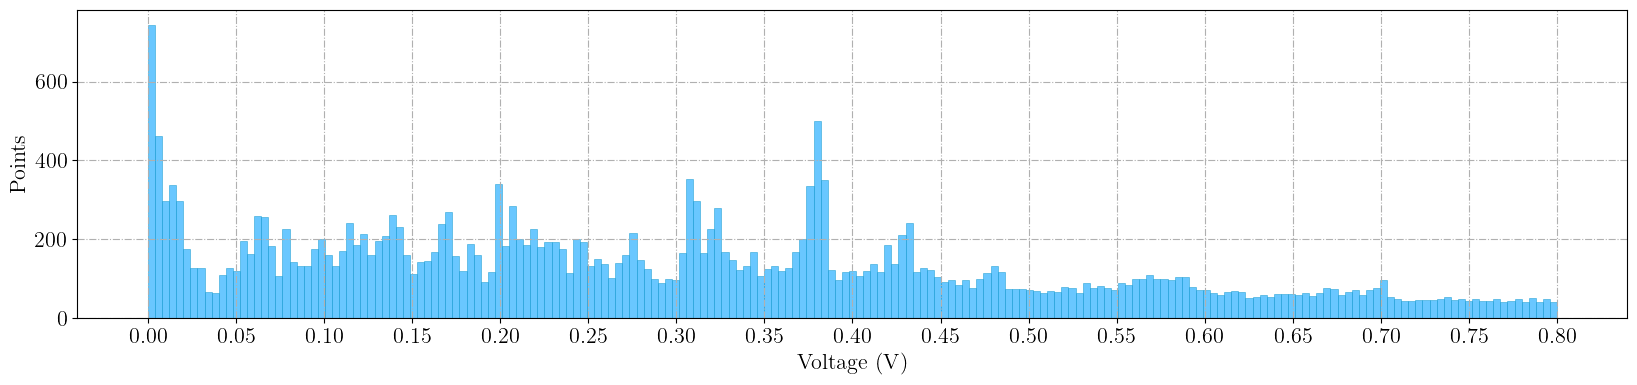

In [ ]:
# We open the files
data = [ pd.read_csv(f'm{i}.csv', header = None) for i in range(1, 24) ]

# We extract the voltages
voltage_counts = pd.concat(data, ignore_index = True)
voltage_counts.columns = ['a','b','c','time','voltage','ignore']

# === Histogram ===
bins = np.linspace(0, 0.8, 200)
figure = voltage_counts.set_index('time')['voltage'].hist(bins = bins,  facecolor = '#2ab0ff', edgecolor = '#169acf', 
                                                          linewidth = 0.5, alpha = 0.7, figsize = (20, 4))
plt.xticks(np.arange(0, 0.805, 0.05))
plt.xlabel(r'Voltage ($\mathrm{V}$)')
plt.ylabel(r'Points')
plt.show()

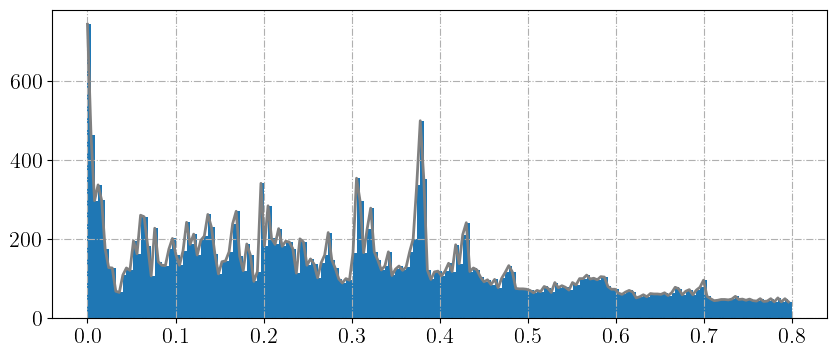

In [4]:
fig, ax = plt.subplots(figsize=(10,4))
counts = voltage_counts.set_index('time')['voltage'].to_list()
histogram = ax.hist(counts, bins=bins)

x, y = histogram[1][:-1], histogram[0]
ax.plot(x,y, color='gray')

plt.show()

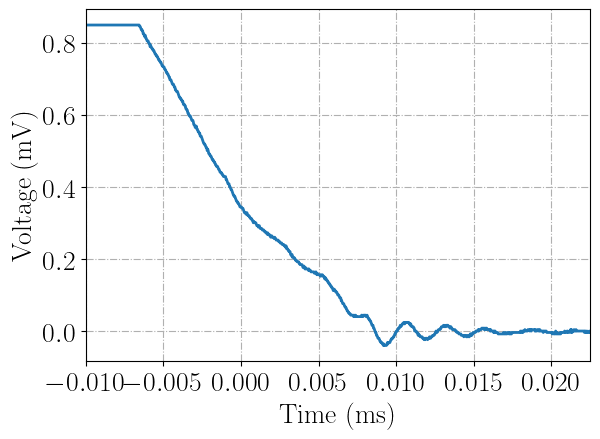

In [ ]:
# Transient
data_1 = pd.read_csv(f'm6.csv', header = None)

# Time (ms) and Voltage (V)
t, V = data_1[3], data_1[4]

# Plot
plt.plot(t * 10 ** 3, V)
plt.xlim(-0.01, 0.0225)
plt.xticks(np.arange(-0.010, 0.021, 0.005))
plt.xlabel(r'Time ($\mathrm{ms}$)')
plt.ylabel(r'Voltage ($\mathrm{mV}$)')
plt.tight_layout()
# plt.savefig('curve.pdf')
plt.show()

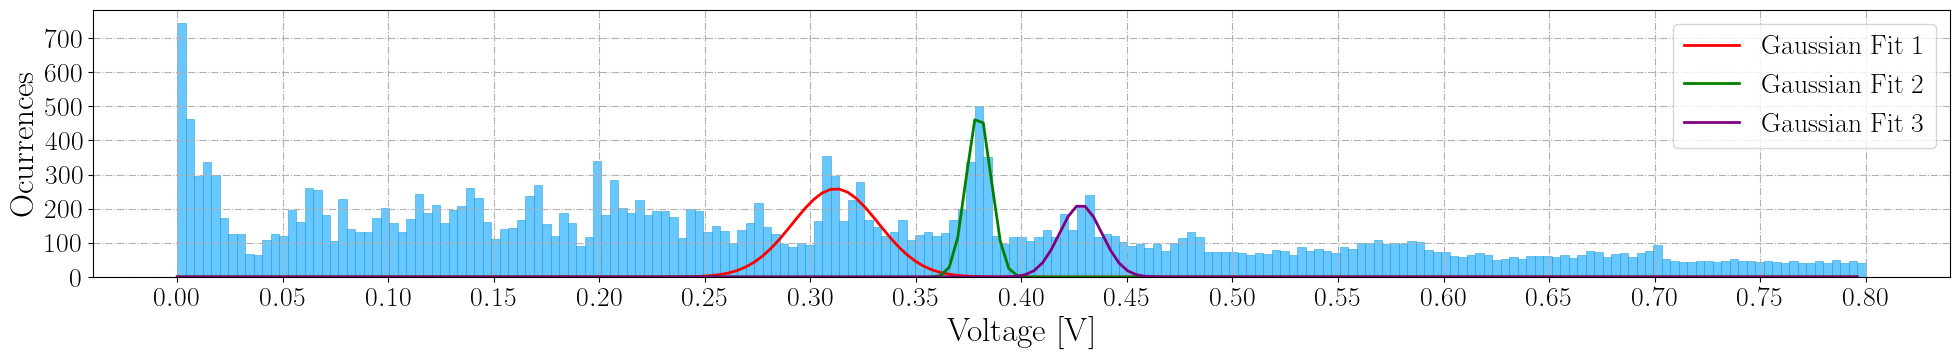

In [ ]:
# Gaussian model function
def Gauss(x, sigma, mu, A):
    y = np.exp(-(x - mu) ** 2 / (2 * sigma ** 2))
    y = y / np.max(y)
    return A * y

def get_gauss_params(bins, guess):
    center, height = bins
    single_gauss_df = pd.DataFrame({'x': center, 'y': height}).query(f"x >= {guess[0]} & x <= {guess[1]}")
    params, errors = curve_fit(Gauss, single_gauss_df['x'], single_gauss_df['y'], p0=[1, np.mean(guess), np.mean(single_gauss_df['y'])])
    return params

# Assuming histogram data is in voltage_counts[4]
bins = np.linspace(0, 0.8, 200)
figure, ax = plt.subplots(figsize = (20, 4))

# Plot the histogram
ax.hist(voltage_counts['voltage'], bins=bins, facecolor='#2ab0ff', edgecolor='#169acf', linewidth=0.5, alpha=0.7)

# Prepare data for fits
hist_data = np.histogram(voltage_counts['voltage'], bins=bins)
bin_heights = hist_data[0]
bin_centers = (hist_data[1][:-1] + hist_data[1][1:]) / 2

# === Gaussian fits ====
# Dictionary to save all the gaussian parameters
params= {}
guesses = [
  [0.30, 0.34],
  [0.37, 0.40],
  [0.42, 0.44]
]
colors = ['red','green','purple']


for (i, guess) in enumerate(guesses):
    
    params[i] = get_gauss_params((bin_centers, bin_heights), guess)
    ax.plot(x, Gauss(x, *params[i]), color = colors[i], label = f'Gaussian Fit {i+1}')
    

# Final plot settings
ax.set_xticks(np.arange(0, 0.805, 0.05))
ax.set_yticks(np.arange(0, 800, 100))
ax.set_xlabel(r'Voltage [$\mathrm{V}$]', fontsize= 24)
ax.set_ylabel(r'Ocurrences', fontsize = 24)
ax.legend()
plt.tight_layout()
plt.savefig('histograma.pdf')
plt.show()

In [82]:
# Statistical parameters
sigma_0, mu_0 = params[0][0], params[0][1]
sigma_1, mu_1 = params[1][0], params[1][1]
sigma_2, mu_2 = params[2][0], params[2][1]

# Voltage difference
Vd_10, std_10 = mu_1 - mu_0, np.sqrt(sigma_1 ** 2 + sigma_0 ** 2)
print(f"Voltage difference between Peak 1 and 2: {Vd_10} ± {std_10}")

Vd_21, std_21 = mu_2 - mu_1, np.sqrt(sigma_2 ** 2 + sigma_1 ** 2)
print(f"Voltage difference between Peak 2 and 3: {Vd_21} ± {std_21}")

Vd_20, std_20 = (mu_2 - mu_0) / 2, np.sqrt(sigma_2 ** 2 + sigma_0 ** 2) / 2
print(f"Voltage difference between Peak 1 and 3: {Vd_20} ± {std_20}")


Voltage difference between Peak 1 and 2: 0.06780578877174365 ± 0.021220447974271053
Voltage difference between Peak 2 and 3: 0.04835545882868819 ± 0.011604395129084785
Voltage difference between Peak 1 and 3: 0.05808062380021592 ± 0.01136076414012869


In [85]:
# Mean voltage step
V_av = (Vd_10 + Vd_21 + Vd_20) / 3
V_av_std = np.sqrt(std_10 ** 2 + std_21 ** 2 + std_20 ** 2) / 3
print(f"Mean voltage step: {V_av} ± {V_av_std}")

# Experimental current step
I_step = V_av / (20 * 10 ** 3)
I_step_unc = V_av_std / (20 * 10 ** 3)
print(f"Current step = {I_step} ± {I_step_unc}")

# Experimental conductance
G_step = I_step / 0.038
G_step_unc = I_step_unc / 0.038
print(f"Conductance = {G_step * 10 ** 6} ± {G_step_unc * 10 ** 6}")

Mean voltage step: 0.05808062380021592 ± 0.008907152933259782
Current step = 2.9040311900107958e-06 ± 4.453576466629891e-07
Conductance = 76.42187342133673 ± 11.71993807007866
